## Notebook for ParaCall performance 
I will perform test with 1 to 16 A100 GPUs on hac and sup basecalling models. To do so I modified the function `compute_resources` inside the `resource_profiler.py` file to use only one profile for every case. So each run I will select the profile by hand and then launch the test

In [2]:
# https://community.nanoporetech.com/requirements_documents/promethion-it-reqs.pdf?from=support
conversion_rate_Gbases_to_GB = 7 
#https://aws.amazon.com/blogs/hpc/benchmarking-the-oxford-nanopore-technologies-basecallers-on-aws/
fast_a100_speed_GB = float('1.63e-02')*conversion_rate_Gbases_to_GB
hac_a100_speed_GB = float('6.58e-03')*conversion_rate_Gbases_to_GB
sup_a100_speed_GB = float('1.24e-03')*conversion_rate_Gbases_to_GB

#Ideal run time with 16 GPUs of 1 h
size = 1*60*60*sup_a100_speed_GB*16
print(f"Size : {size} GB")

Size : 499.968 GB


So I'll use the flowcell4 from the ONT open dataset HG002, which has a size of 299 GB. Each run will produce a .csv file inside each server dir. I need to save them in this dir and then parse them. Moreover, I'll take the starting time of the basecalling pipeline and the end time to also create a plot to asses the overhead generated by the steps.  
Probably, I'll need to remove the 0% usage tail that each run has

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_gpu_usage(log_file, output_image):
    # Load the log data
    df = pd.read_csv(log_file)

    # Convert timestamp column to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create a plot for each GPU
    plt.figure(figsize=(10, 5))
    for gpu_id in df['gpu_id'].unique():
        gpu_data = df[df['gpu_id'] == gpu_id]
        plt.plot(gpu_data['timestamp'], gpu_data['gpu_usage'], label=f'GPU {gpu_id}')

    # Customize plot
    plt.xlabel('Time')
    plt.ylabel('GPU Usage (%)')
    plt.title('GPU Usage Over Time')
    plt.legend()

    # Save the plot to an image file
    plt.savefig(output_image)
    print(f"Plot saved to {output_image}")

Plot saved to /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/1_gpu.png
Plot saved to /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/2_gpu.png
Plot saved to /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/3_gpu.png


FileNotFoundError: [Errno 2] No such file or directory: '/orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/4_gpu.csv'

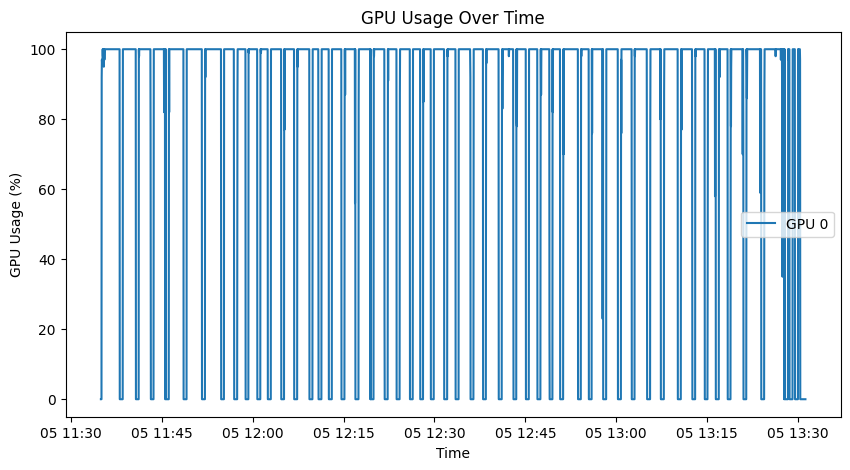

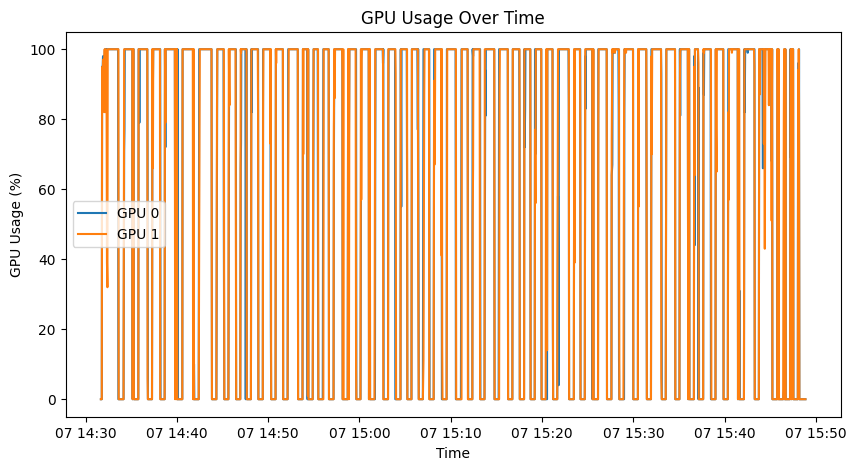

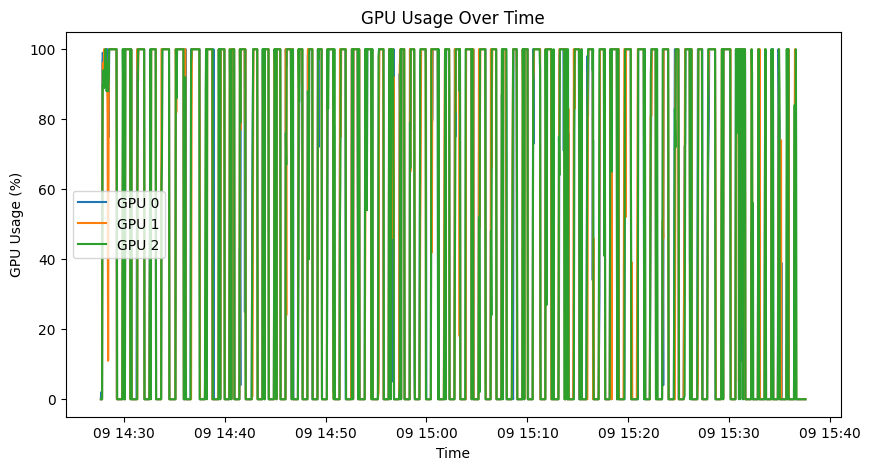

In [8]:
path_to_csv = "/orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv"

for i in range(1, 5):
    plot_gpu_usage(f"{path_to_csv}/{i}_gpu.csv", f"{path_to_csv}/{i}_gpu.png")

In [5]:

def compute_stats(log_file, dataset_size_GB = 299):
    # Load the log data
    df = pd.read_csv(log_file)

    df['timestamp'] = pd.to_datetime(df['timestamp'])
    start_time = df['timestamp'].min()
    end_time = df['timestamp'].max()
    duration = end_time - start_time
    speed = dataset_size_GB / duration.total_seconds()

    number_of_gpus = len(df.groupby('gpu_id')['gpu_usage'])

    total_stats = pd.DataFrame({"GPUs":number_of_gpus, "Duration":duration.total_seconds(), "Speed GB/s":speed}, index=[0])
    gpus_stats = df.groupby('gpu_id')['gpu_usage'].agg(['mean', 'std', 'min', 'max'])

    print(f"Stats from {log_file}")
    #display(total_stats)
    display(gpus_stats)
    return  total_stats

def benchmark_results(array_log_files):
    results = pd.DataFrame()
    for log_file in array_log_files:
        results = pd.concat([results, compute_stats(log_file)], ignore_index=True)
    print("---------Benchmark results---------")
    return results


In [6]:

compute_stats(f"{path_to_csv}/1_gpu.csv")
compute_stats(f"{path_to_csv}/2_gpu.csv")

Stats from /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/1_gpu.csv


,mean,std,min,max
gpu_id,,,,
0,76.240442,42.273405,0,100


Stats from /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/2_gpu.csv


,mean,std,min,max
gpu_id,,,,
0,60.431589,48.315978,0,100
1,60.349862,48.300304,0,100


,GPUs,Duration,Speed GB/s
0,2,4630.0,0.064579


Stats from /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/1_gpu.csv


,mean,std,min,max
gpu_id,,,,
0,76.240442,42.273405,0,100


Stats from /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/2_gpu.csv


,mean,std,min,max
gpu_id,,,,
0,60.431589,48.315978,0,100
1,60.349862,48.300304,0,100


Stats from /orfeo/cephfs/scratch/area/jenkins_onpexp/GPU_basecalling_benchmark/csv/3_gpu.csv


,mean,std,min,max
gpu_id,,,,
0,46.329504,48.950005,0,100
1,46.425065,48.949433,0,100
2,46.585379,49.013213,0,100


---------Benchmark results---------


,GPUs,Duration,Speed GB/s
0,1,6975.0,0.042867
1,2,4630.0,0.064579
2,3,4187.0,0.071412


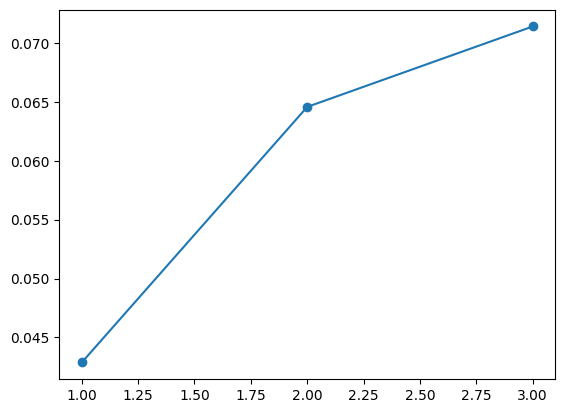

In [13]:
logs_file = [f"{path_to_csv}/{i}_gpu.csv" for i in range(1, 4)]
results = benchmark_results(logs_file)

display(results)
plt.plot(results['GPUs'], results['Speed GB/s'], marker='o')